
# Module 4 Session 2 - Quantifying Health Disparities

## Authors: Shivam Sharma & Vincent Lam 

#### Date: May 29, 2024


## Section 1 - Data exploration

In [5]:
rm(list=ls())
set.seed(13)

library("data.table")
library("dplyr")
library("parallel")
library('stringr')
library('ggplot2')
library('readr')

options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 120)

If any of the above packages are unavailable, they can be installed like so:

install.packages('package_name')

In [6]:
# Load the files for our cohort.
cohort = as.data.frame(fread("../Data/Session2/ParticipantCohort.tsv"))
range(cohort$ParticipantID)
dim(cohort)
head(cohort)

ehr_records = as.data.frame(fread("../Data/Session2/ParticipantEHR.tsv"))
dim(ehr_records)
head(ehr_records)

[1] 10001701 99999942

[1] 50000     4

,ParticipantID,Age,Sex,SIRE
,<int>,<dbl>,<chr>,<chr>
1,72855012,18.50098,F,Black
2,60709423,18.00000,F,Black
3,30963548,21.44716,F,Black
4,76818295,24.45020,F,Black
5,68693481,20.64606,F,Black
6,61809284,23.00696,F,Black


[1] 499870      2

,ParticipantID,ICD10CM
,<int>,<chr>
1,72855012,D46.C
2,72855012,S27.421
3,72855012,S72.022A
4,72855012,S82.892S
5,72855012,M96.840
6,72855012,S56.202S


In [7]:
#Explore the data a little bit.
cohort %>% count(SIRE, Sex)
cohort %>% group_by(SIRE, Sex) %>% summarize(MeanAge = mean(Age))

SIRE,Sex,n
<chr>,<chr>,<int>
Black,F,4670
Black,M,2759
Hispanic,F,7436
Hispanic,M,2990
White,F,20314
White,M,11831


`summarise()` has grouped output by 'SIRE'. You can override using the `.groups` argument.


SIRE,Sex,MeanAge
<chr>,<chr>,<dbl>
Black,F,48.04122
Black,M,47.88016
Hispanic,F,50.08872
Hispanic,M,50.05681
White,F,46.27746
White,M,46.37888


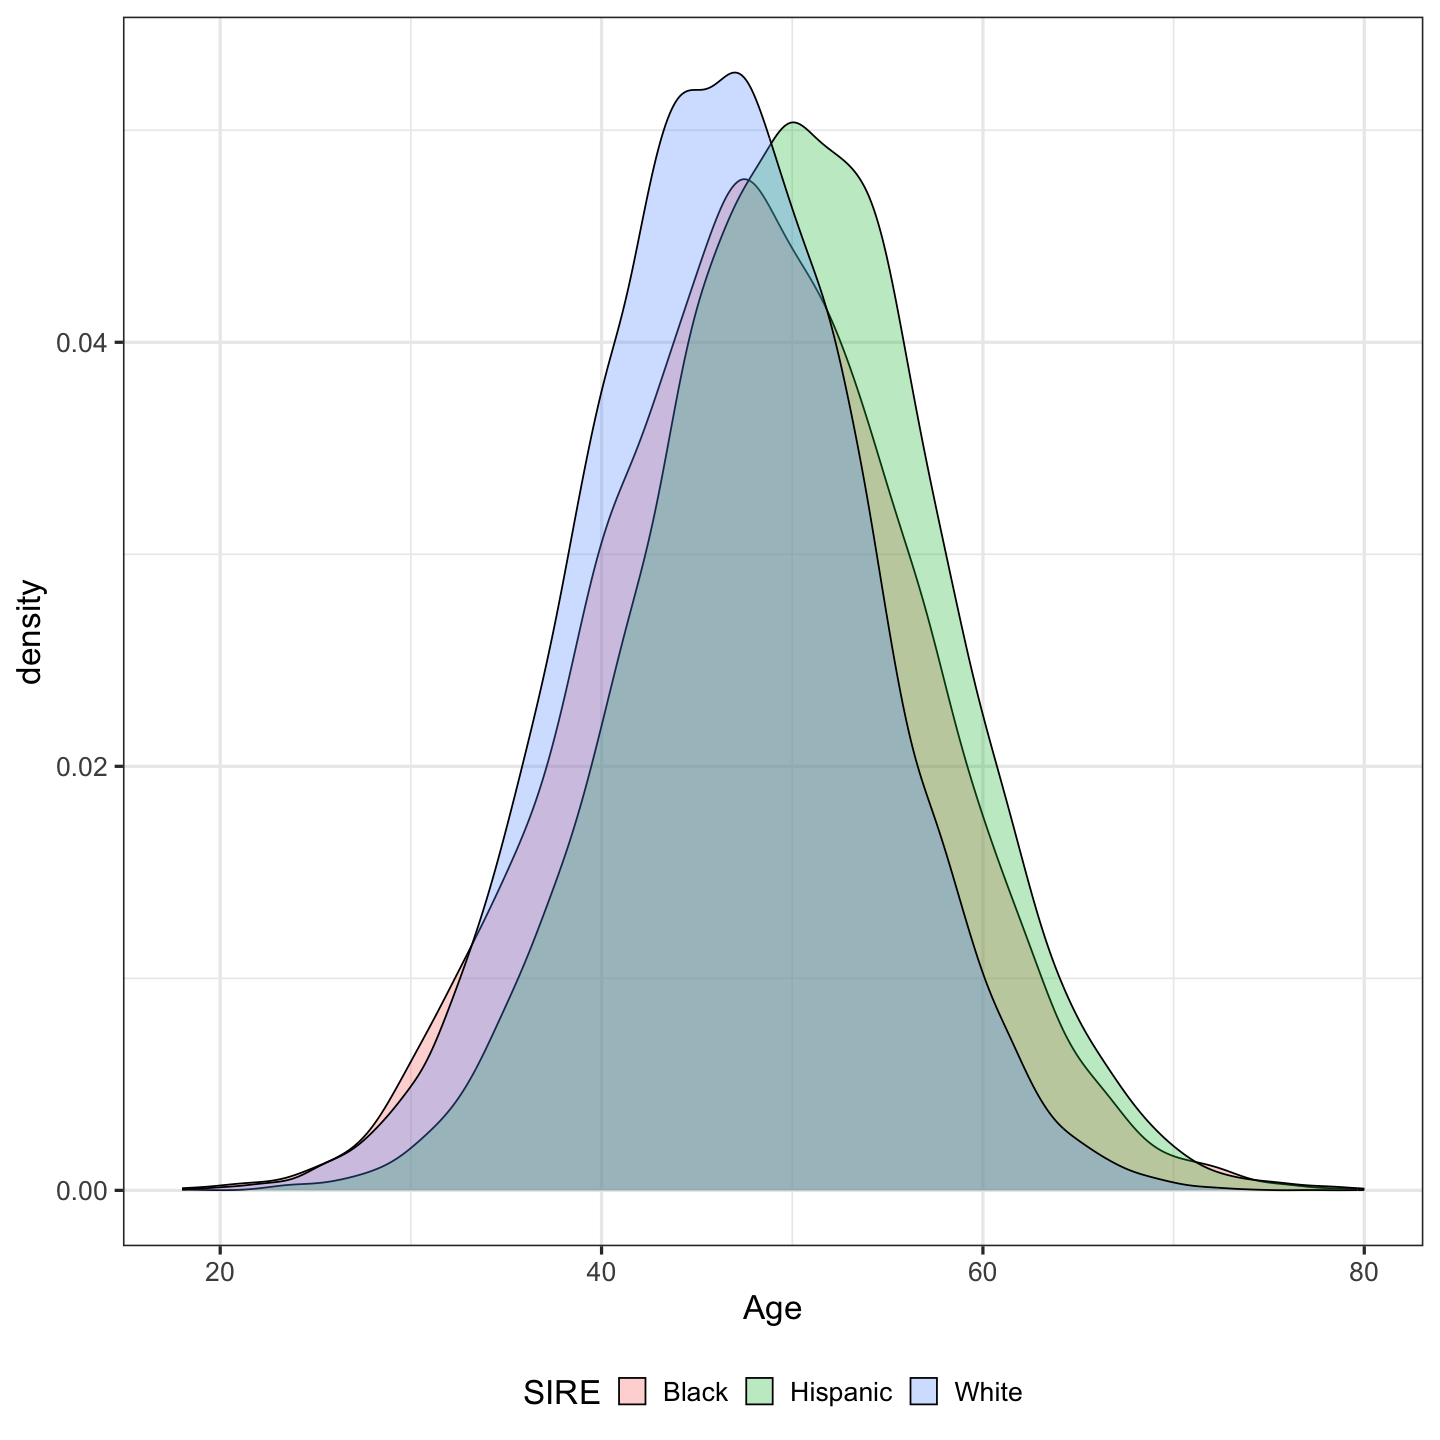

In [8]:
# Visualzie the density of age distribution.
ggplot(cohort, aes(x = Age, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

In [9]:
#Let's have a look at the EHR records.
print("Number of rows in our EHR df: ")
dim(ehr_records)

#See the number of people in the EHR data.
print("Number of participants that have EHR records: ")
length(unique(ehr_records$ParticipantID))

print("Number of unique EHR records: ")
length(unique(ehr_records$ICD10CM))


[1] "Number of rows in our EHR df: "


[1] 499870      2

[1] "Number of participants that have EHR records: "


[1] 50000

[1] "Number of unique EHR records: "


[1] 47733

## Section 2 - Create case-control cohorts

In [10]:
# Read the phecode map for ICD10CM codes.
# This map file is downloaded from the PheWAS Catalog: https://phewascatalog.org/
phecode_map = as.data.frame(fread("../Data/Session2/Phecode_map_v1_2_icd10cm_beta.csv"))
dim(phecode_map)
head(phecode_map)

[1] 90835     8

,icd10cm,icd10cm_str,phecode,phecode_str,exclude_range,exclude_name,leaf,rollup
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>
1,S05.22XD,"Ocular laceration and rupture with prolapse or loss of intraocular tissue, left eye, subsequent encounter",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
2,S01.101S,"Unspecified open wound of right eyelid and periocular area, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
3,S01.102S,"Unspecified open wound of left eyelid and periocular area, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
4,S05.22XA,"Ocular laceration and rupture with prolapse or loss of intraocular tissue, left eye, initial encounter",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
5,S01.149S,"Puncture wound with foreign body of unspecified eyelid and periocular area, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
6,S05.61XS,"Penetrating wound without foreign body of right eyeball, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1


In [11]:
# Extract the IDC10CM codes for our disease of interest: Type 2 Diabetes.
phecode_map_t2d = phecode_map %>% filter(phecode_str == "Type 2 diabetes")
dim(phecode_map_t2d)
head(phecode_map_t2d)

[1] 24  8

,icd10cm,icd10cm_str,phecode,phecode_str,exclude_range,exclude_name,leaf,rollup
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>
1,E11.6,Type 2 diabetes mellitus with other specified complications,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
2,E11.64,Type 2 diabetes mellitus with hypoglycemia,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
3,E11.649,Type 2 diabetes mellitus with hypoglycemia without coma,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
4,E11.641,Type 2 diabetes mellitus with hypoglycemia with coma,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
5,E11.630,Type 2 diabetes mellitus with periodontal disease,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
6,E11.69,Type 2 diabetes mellitus with other specified complication,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1


In [12]:
#Label if an EHR entry is for T2D or not.
ehr_records = ehr_records %>% mutate(T2D_Code = case_when(ICD10CM %in% phecode_map_t2d$icd10cm ~ 1, .default = 0))
dim(ehr_records)
head(ehr_records)

[1] 499870      3

,ParticipantID,ICD10CM,T2D_Code
,<int>,<chr>,<dbl>
1,72855012,D46.C,0
2,72855012,S27.421,0
3,72855012,S72.022A,0
4,72855012,S82.892S,0
5,72855012,M96.840,0
6,72855012,S56.202S,0


In [13]:
# If a participant has at least 1 T2D code, then they are a case, otherwise they are a control.
case_control_cohort <- ehr_records %>%
                        group_by(ParticipantID) %>%
                        summarize(T2DStatus = max(T2D_Code)) %>%
                        as.data.frame()

dim(case_control_cohort)
head(case_control_cohort)

[1] 50000     2

,ParticipantID,T2DStatus
,<int>,<dbl>
1,10001701,0
2,10004576,0
3,10006792,0
4,10007268,0
5,10008364,0
6,10008475,1


In [14]:
case_control_cohort = merge(case_control_cohort, cohort, by = "ParticipantID")
dim(case_control_cohort)
head(case_control_cohort)

[1] 50000     5

,ParticipantID,T2DStatus,Age,Sex,SIRE
,<int>,<dbl>,<dbl>,<chr>,<chr>
1,10001701,0,50.73368,M,White
2,10004576,0,57.51144,F,Black
3,10006792,0,52.70796,F,White
4,10007268,0,49.73393,F,Hispanic
5,10008364,0,43.61219,F,White
6,10008475,1,66.53269,M,Hispanic


In [15]:
case_control_cohort %>% group_by(SIRE, Sex) %>% count(T2DStatus)

SIRE,Sex,T2DStatus,n
<chr>,<chr>,<dbl>,<int>
Black,F,0,3629
Black,F,1,1041
Black,M,0,2077
Black,M,1,682
Hispanic,F,0,5545
Hispanic,F,1,1891
Hispanic,M,0,2080
Hispanic,M,1,910
White,F,0,18156


In [ ]:
# Save the results to a TSV file.
write.table(x = case_control_cohort %>% dplyr::select(ParticipantID, T2DStatus),
                file = "../Data//Session2/ParticipantT2DStatus.tsv",
                quote = F,
                sep = "\t",
                row.names = F)

In [28]:
# Save the results to a TSV file for Session4 as well.
write.table(x = case_control_cohort %>% dplyr::select(ParticipantID, T2DStatus),
                file = "../Data//Session4/ParticipantT2DStatus.tsv",
                quote = F,
                sep = "\t",
                row.names = F)

## Section 3 - Calculate age & sex adjusted prevalences

The goal of this section is to calculate race-specific prevalence estimates of type 2 diabetes in our cohort. A paper published in the journal Clinical Diabetes provides national estimates for race-specific type 2 diabetes prevalence: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5241767/#:~:text=The%20prevalence%20of%20diagnosed%20type,non%2DHispanic%20whites%207.6%25. Furthermore, CDC estimates suggest that the nationwide prevalence for type 2 diabetes is roughly 10.74%: https://www.uptodate.com/contents/type-2-diabetes-mellitus-prevalence-and-risk-factors/print#:~:text=Other%20national%20databases%2C%20such%20as,undiagnosed%2C%20and%2095%20percent%20of. These figures give an idea of how type 2 diabetes cases may be patterned in our cohort. To get a better sense of what these national estimates convey, we can plot them as a bar plot. We begin by formatting the paper's type 2 diabetes estimates for Black, Hispanic, and White individuals as a tibble:

In [13]:
# Creating table of national estimates to be plotted
SIRE_col = factor(c('Black','Hispanic','White', 'Overall'), levels = c('Black','Hispanic','White', 'Overall'))
prev_col = c(13.2, 12.8, 7.6, 10.74)
nat_est_df = tibble(SIRE = SIRE_col, Prevalence = prev_col)
nat_est_df

SIRE,Prevalence
<fct>,<dbl>
Black,13.20
Hispanic,12.80
White,7.60
Overall,10.74


After this, we can plot the tibble with SIRE on the x-axis and prevalence estimates on the y-axis:

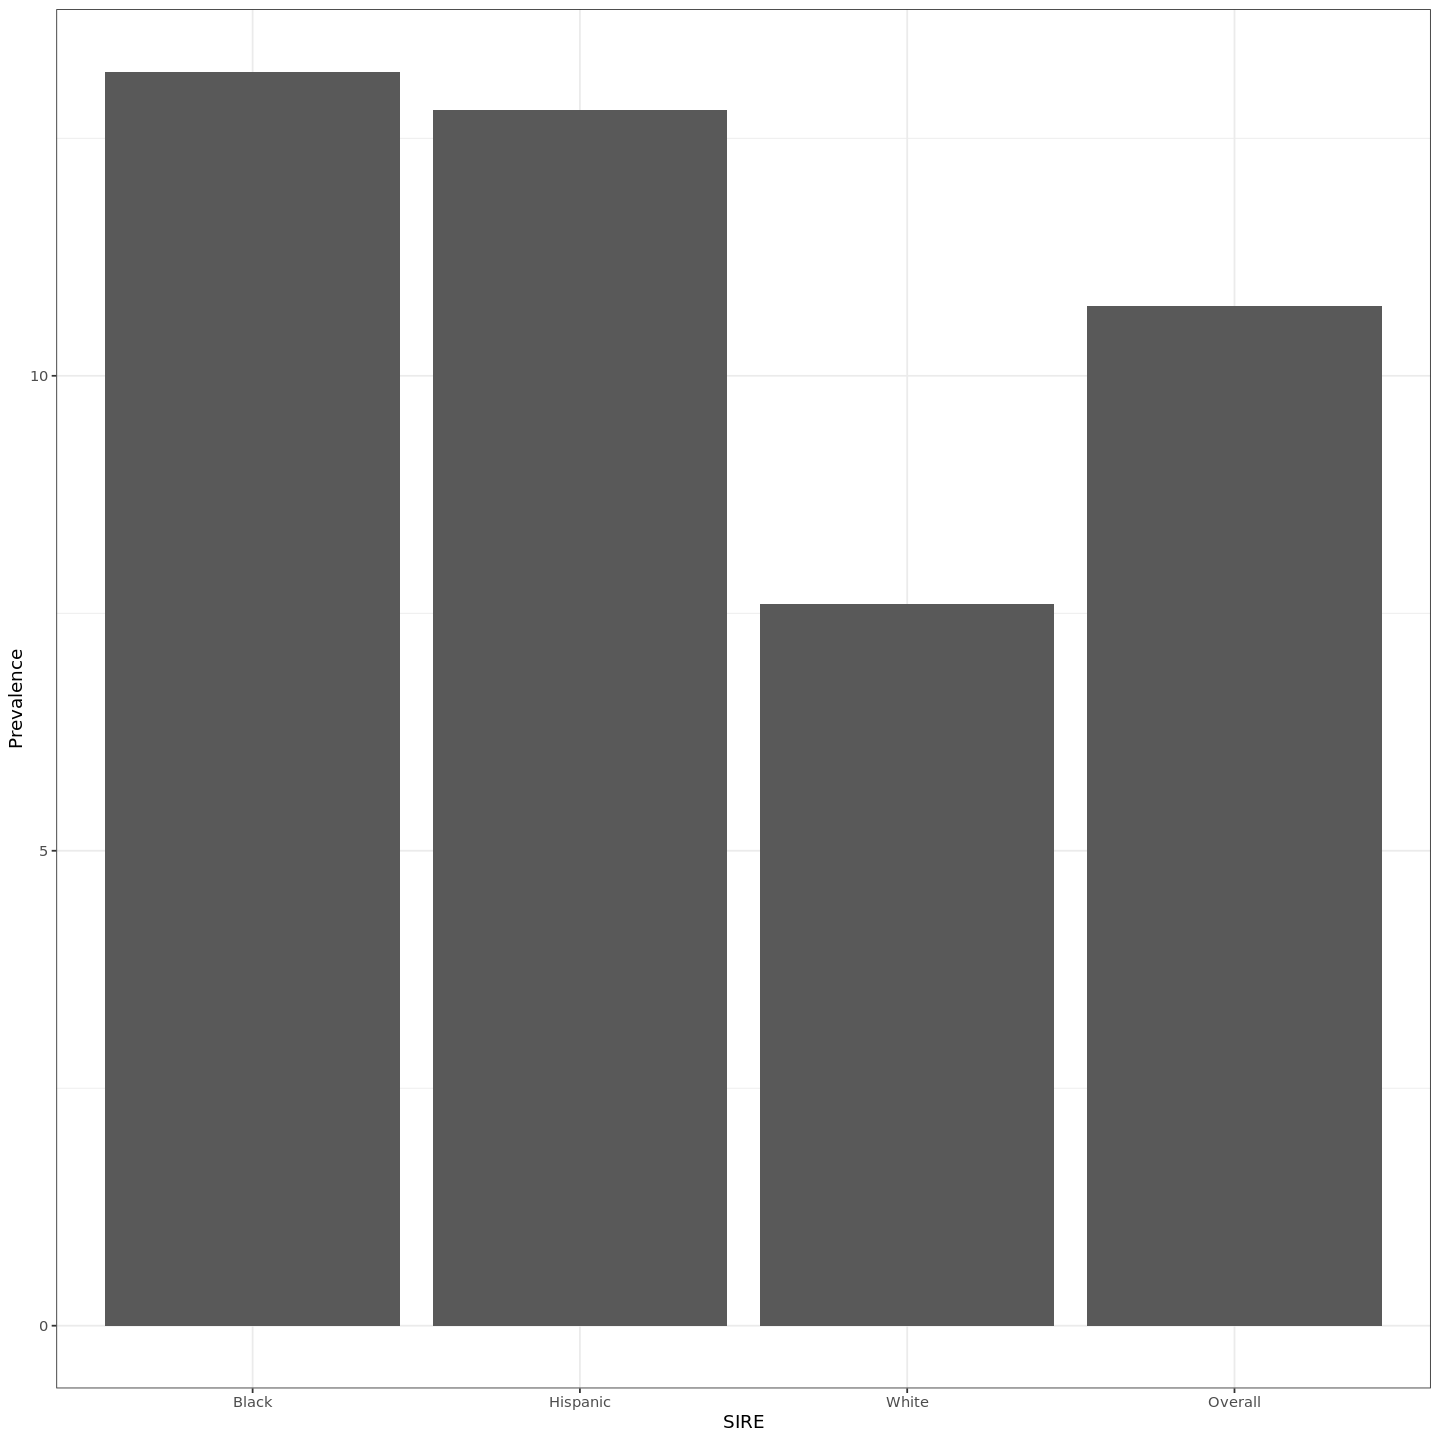

In [14]:
# Plotting table of national estimates
ggplot(data = nat_est_df, mapping = aes(x = SIRE, y = Prevalence)) +
geom_bar(stat = 'identity') +
theme_bw()

National estimates for type 2 diabetes prevalence clearly show that Black and Hispanic individuals have a disproportionately high type 2 diabetes burden relative to their White counterparts. Is the same true for our cohort? We can apply the same plotting steps to our own data. Let's have a look at how our data is structured:

In [60]:
# Loading in our cohort data
cohort_df = as.data.frame(fread("../Data/Session2/ParticipantCohort.tsv"))
# Viewing the first few rows of our cohort
head(cohort_df)

Rows: 50000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Sex, SIRE
dbl (2): ParticipantID, Age

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,ParticipantID,Age,Sex,SIRE
,<int>,<dbl>,<chr>,<chr>
1,72855012,18.50098,F,Black
2,60709423,18.00000,F,Black
3,30963548,21.44716,F,Black
4,76818295,24.45020,F,Black
5,68693481,20.64606,F,Black
6,61809284,23.00696,F,Black


In [61]:
# Loading in our T2D status data
t2d_df = as.data.frame(fread("../Data/Session2/ParticipantT2DStatus.tsv"))
# Viewing the first few rows of our cohort
head(t2d_df)

Rows: 50000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): ParticipantID, T2DStatus

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,ParticipantID,T2DStatus
,<int>,<int>
1,10001701,0
2,10004576,0
3,10006792,0
4,10007268,0
5,10008364,0
6,10008475,1


In [62]:
# Adding type 2 diabetes case data to cohort tibble
cohort_df = merge(cohort_df, t2d_df)
# Renaming status column
colnames(cohort_df)[5] = 't2d'
# Viewing merged table
head(cohort_df)

,ParticipantID,Age,Sex,SIRE,t2d
,<int>,<dbl>,<chr>,<chr>,<int>
1,10001701,50.73368,M,White,0
2,10004576,57.51144,F,Black,0
3,10006792,52.70796,F,White,0
4,10007268,49.73393,F,Hispanic,0
5,10008364,43.61219,F,White,0
6,10008475,66.53269,M,Hispanic,1


The 't2d' column can be used to calculate raw type 2 diabetes prevalence estimates for each of our three SIRE groups. In this column, 1s represent individuals with type 2 diabetes (cases), and 0s represent individuals without type 2 diabetes (controls). Taking raw prevalence to be equal to (# of cases in group) / (# of people in group), we can get # of cases in each SIRE group by summing the 1s in the 't2d' column for each SIRE group:

In [63]:
# Creating a tibble with sums of the 't2d' column for each distinct SIRE group in our cohort
cohort_raw_prev_df = cohort_df %>%
  group_by(SIRE) %>%
  summarize(cases = sum(t2d))
# Adding a row with the sum of type 2 diabetes cases across all SIRE groups
cohort_raw_prev_df = rbind(cohort_raw_prev_df, tibble(SIRE = 'Overall',cases = sum(cohort_raw_prev_df$cases)))
# Viewing tibble
cohort_raw_prev_df

SIRE,cases
<chr>,<int>
Black,1723
Hispanic,2801
White,3585
Overall,8109


The 'count' function can be used to obtain the number of people within each SIRE group:

In [64]:
# Counting the number of individuals by SIRE label in our cohort
count_df = count(cohort_df, SIRE)
# Adding a row with the sum of individuals across the entire cohort
count_df = rbind(count_df, tibble(SIRE = 'Overall',n = nrow(cohort_df)))
# View table
count_df

SIRE,n
<chr>,<int>
Black,7429
Hispanic,10426
White,32145
Overall,50000


After appending the 'n' column to our original cohort_raw_prev_df tibble, we can simply divide the number of cases by 'n' to get our raw prevalence estimate for each group. Multiplying these results by 100 gives us these results as percentages. 

In [65]:
# Appending the 'n' column to our original cohort_raw_prev_df tibble
cohort_raw_prev_df$n = count_df$n
# Showing the updated tibble
cohort_raw_prev_df

SIRE,cases,n
<chr>,<int>,<int>
Black,1723,7429
Hispanic,2801,10426
White,3585,32145
Overall,8109,50000


In [66]:
# Calculating raw type 2 diabetes prevalence estimates
cohort_raw_prev_df$Prevalence = (cohort_raw_prev_df$cases/cohort_raw_prev_df$n)*100
# Showing the updated tibble
cohort_raw_prev_df

SIRE,cases,n,Prevalence
<chr>,<int>,<int>,<dbl>
Black,1723,7429,23.19289
Hispanic,2801,10426,26.86553
White,3585,32145,11.15259
Overall,8109,50000,16.21800


Let's visualize the raw prevalence estimates we've just calculated:

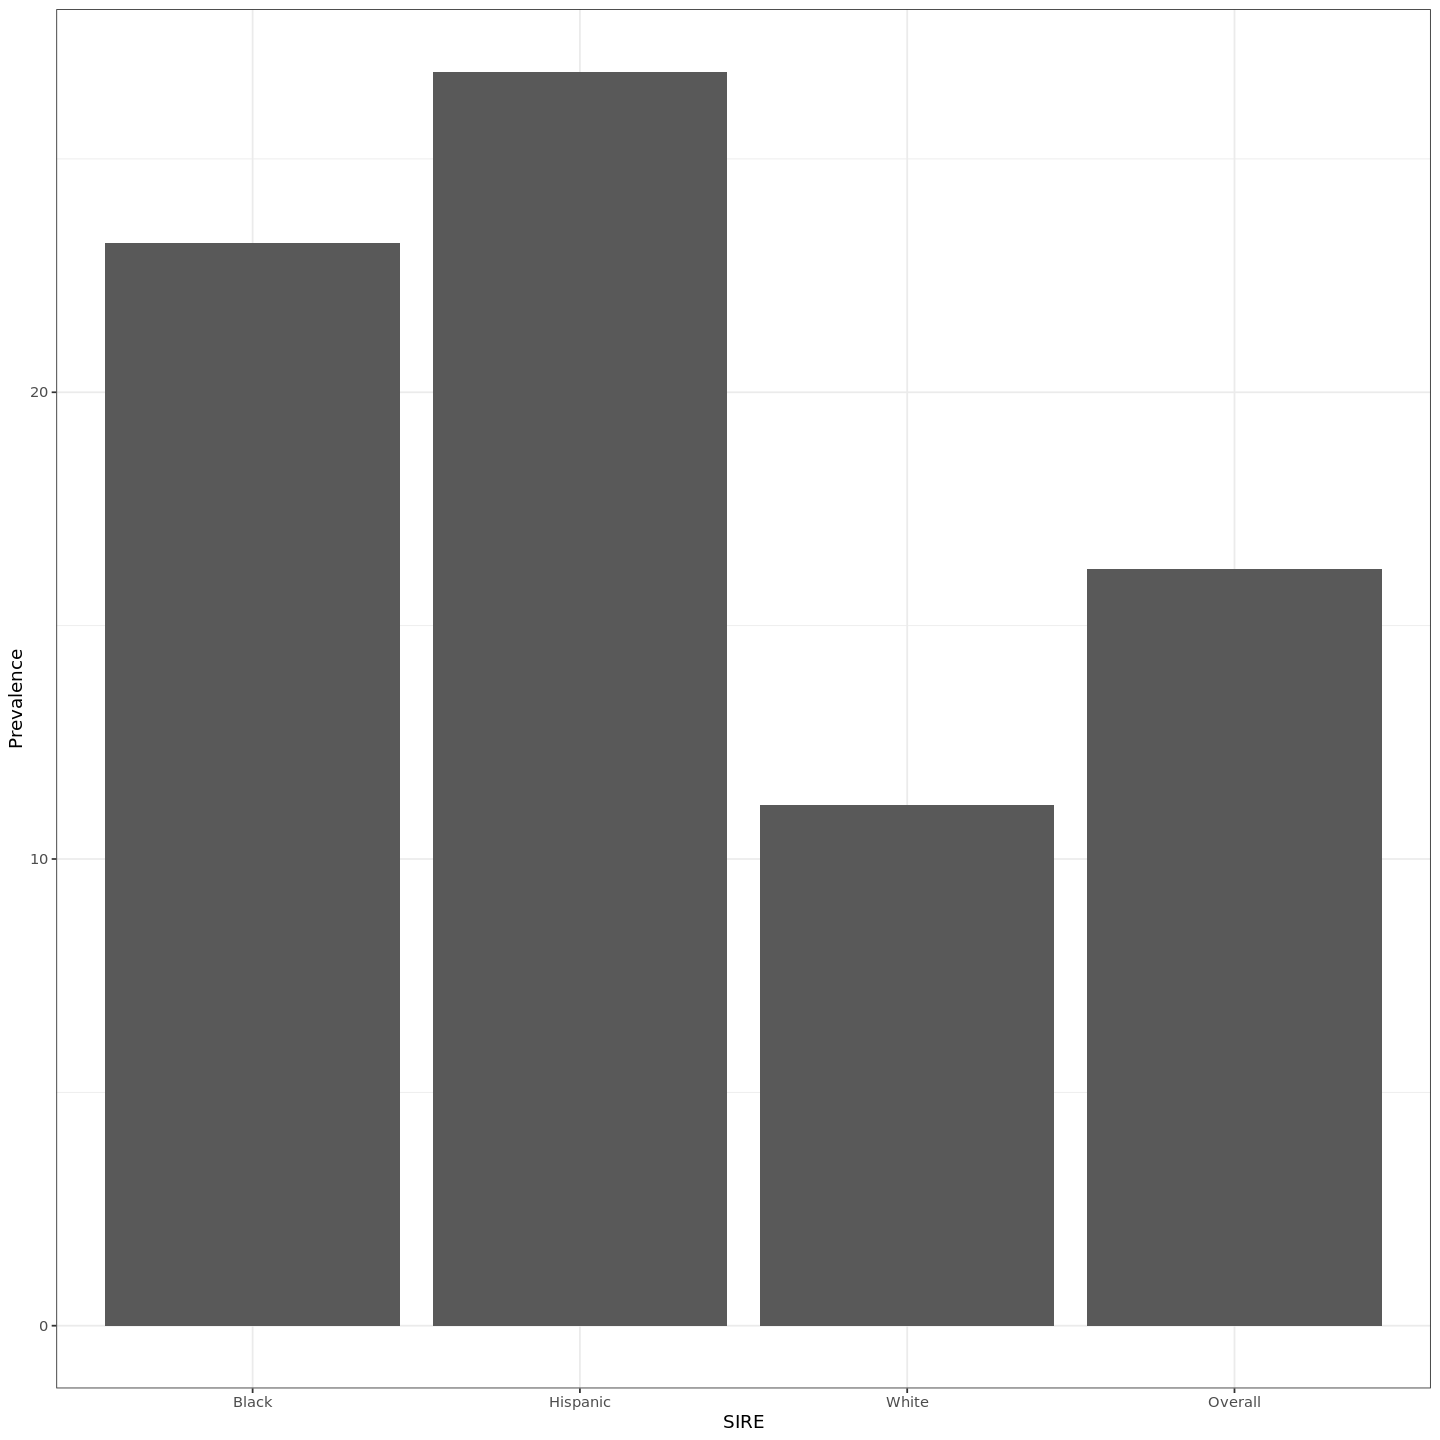

In [67]:
# Coding SIRE column so that SIRE categories are plotted in alphabetical order
cohort_raw_prev_df$SIRE = factor(cohort_raw_prev_df$SIRE, levels = cohort_raw_prev_df$SIRE)
# Plotting table of raw prevalence estimates
ggplot(data = cohort_raw_prev_df, mapping = aes(x = SIRE, y = Prevalence)) +
geom_bar(stat = 'identity') +
theme_bw()

The type 2 diabetes prevalence estimates we calculated for our cohort appear to be patterned the same way as the race-specific national estimates we saw before. Burden for type 2 diabetes appears to be higher among Black and Hispanic individuals than in White individuals. To make this comparison easier, we can plot the estimates we calculated and the national estimates for type 2 diabetes prevalence side-by-side using a grouped bar plot. We begin by combining our two estimate tibbles into one:

In [68]:
# Adding "National" and "Cohort" labels, allowing us to tell whether each prevalence estimate is a national estimate 
# or an estimate calculated from our cohort
nat_est_df$Estimate = 'National'
cohort_raw_prev_df$Estimate = 'Cohort'

In [69]:
# Combining prevalence estimate tibbles, keeping only columns common to both datasets
combined_df = rbind(nat_est_df, cohort_raw_prev_df[c('SIRE','Prevalence','Estimate')])
# Viewing combined tibbles
combined_df

SIRE,Prevalence,Estimate
<fct>,<dbl>,<chr>
Black,13.20000,National
Hispanic,12.80000,National
White,7.60000,National
Overall,10.74000,National
Black,23.19289,Cohort
Hispanic,26.86553,Cohort
White,11.15259,Cohort
Overall,16.21800,Cohort


With our combined tibble ready, let's plot both sets of estimates in a single plot:

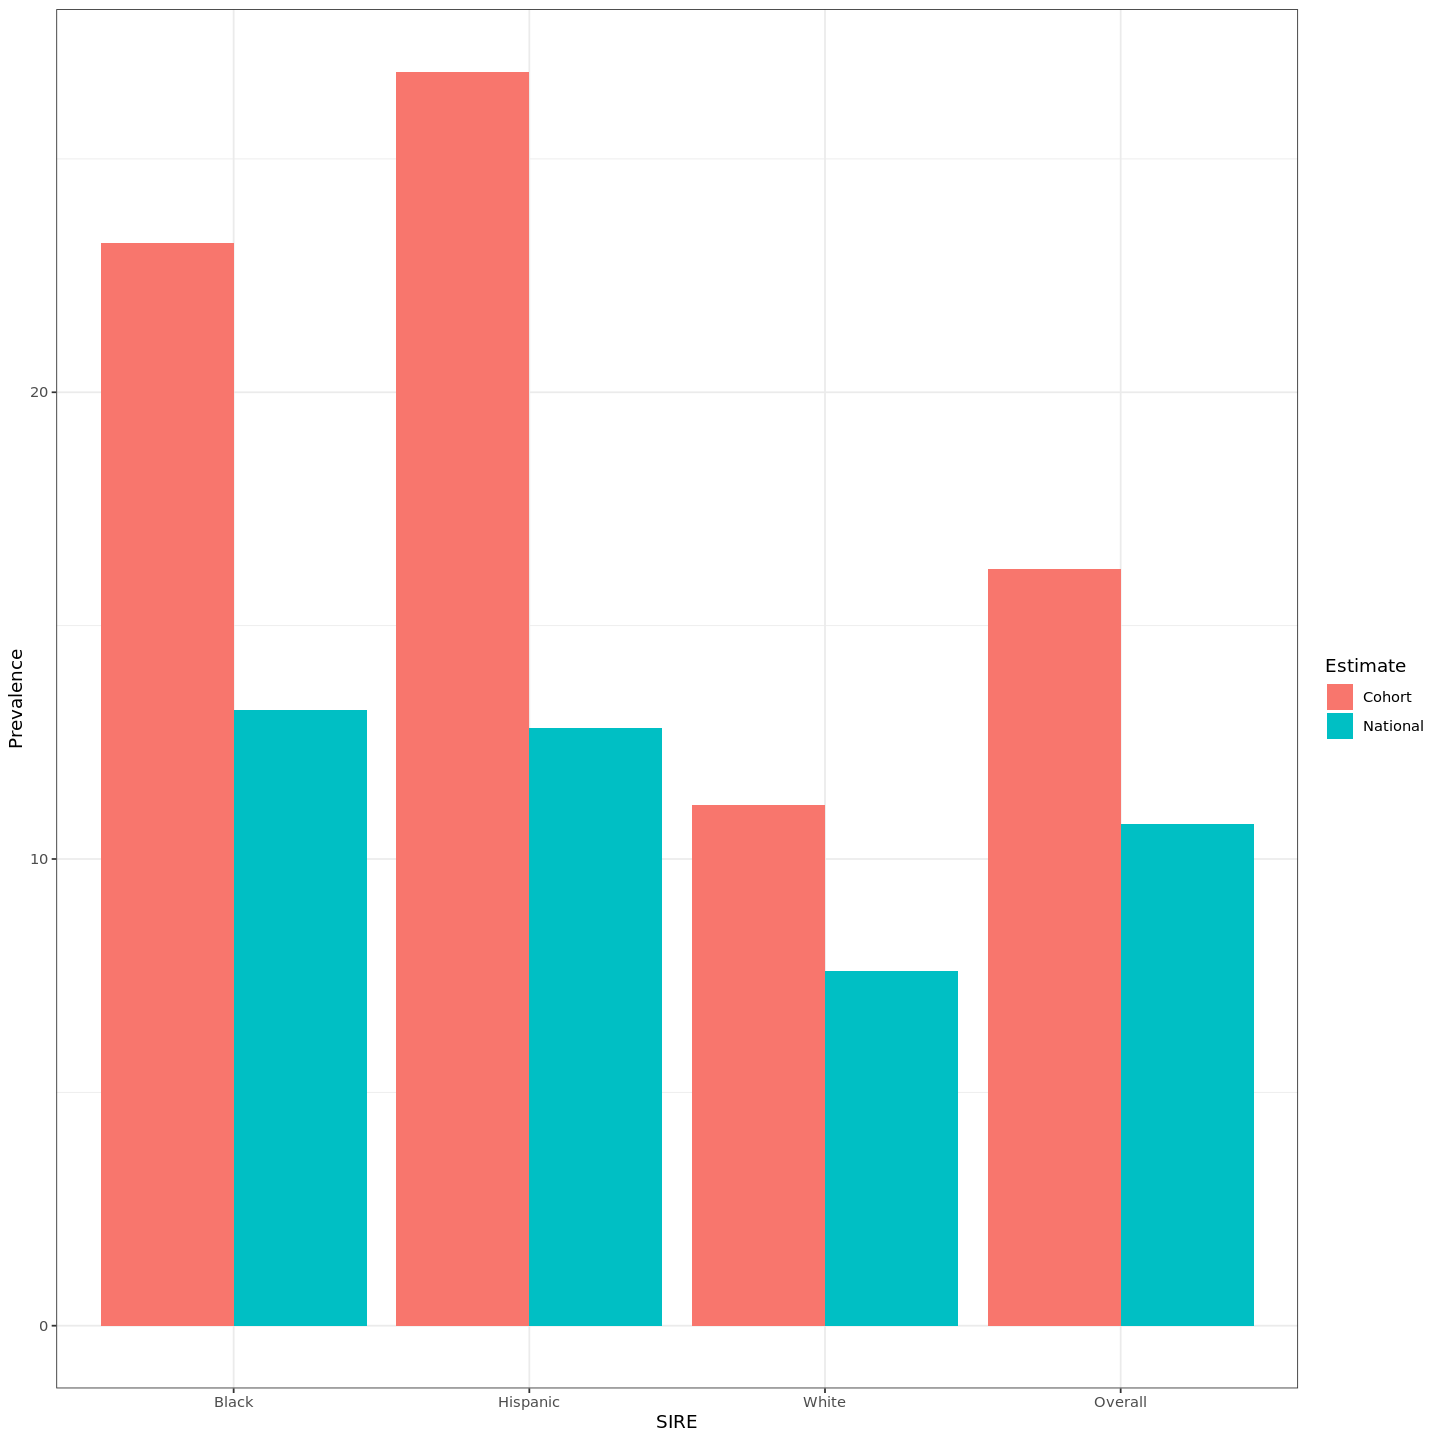

In [70]:
# Plotting table of raw prevalence estimates
ggplot(data = combined_df, mapping = aes(x = SIRE, y = Prevalence, fill = Estimate)) +
# Specify that we'd like a grouped bar plot using the argument 'position = 'dodge''
geom_bar(stat = 'identity', position = 'dodge') +
theme_bw()

This bar plot shows our cohort prevalence estimates to be almost double the figures seen in national estimates. How can this be? While the national estimates are nationally representative, our cohort represents a volunteer sample. It is likely that volunteer bias caused our prevalence estimates to deviate from the actual prevalence of diabetes in the U.S. population. To investigate how our cohort may be different from the general U.S. population, let's take another look at our cohort:

In [71]:
# Viewing first few rows of our cohort
head(cohort_df)

,ParticipantID,Age,Sex,SIRE,t2d
,<int>,<dbl>,<chr>,<chr>,<int>
1,10001701,50.73368,M,White,0
2,10004576,57.51144,F,Black,0
3,10006792,52.70796,F,White,0
4,10007268,49.73393,F,Hispanic,0
5,10008364,43.61219,F,White,0
6,10008475,66.53269,M,Hispanic,1


Aside from SIRE and type 2 diabetes status, we're also given the age and sex of each participant. The median age of the U.S. in 2022 was 38.5, and the ratio of men to women is roughly 50:50. How does this compare to our cohort?

In [72]:
# Caclulating median age for our cohort
median_age = round(median(cohort_df$Age), digits = 2)
# Displaying result
print(c('Median age of cohort:', median_age))

[1] "Median age of cohort:" "47.31"                


In [73]:
# Getting pecrentages of male and female participants
percentages = count(cohort_df, Sex)$n/nrow(cohort_df)*100
# Assembling tibble of male and female percent makeup
sex_df = tibble(Sex = c('Female','Male'), Percent = percentages)
# Viewing tibble
sex_df

Sex,Percent
<chr>,<dbl>
Female,64.84
Male,35.16


As seen above, the average participant in our cohort is more likely to be female and older than the general population. This has a reasonable chance of introducing bias to our prevalence estimations. As such, it is advisable to adjust for both age and sex in our prevalence calculations. This can be accomplished by using representative age and sex-specific population counts to apply weights to our cohort data. Here, we will be using data from the U.S. census: https://data.census.gov/table/ACSDT1Y2021.B01001?text=B01001. These data represents 2021 population estimates from the American Community Survey, which are broken down by race, age, and sex. In the following code, we load this data and examine its contents:

In [117]:
# Loading SIRE-specific and overall census counts
white_census_data_df = as.data.frame(fread("../Data/Session2/white_census_data_df.csv"))
black_census_data_df = as.data.frame(fread("../Data/Session2/black_census_data_df.csv"))
hispanic_census_data_df = as.data.frame(fread("../Data/Session2/hispanic_census_data_df.csv"))
all_census_data_df = as.data.frame(fread("../Data/Session2/all_census_data_df.csv"))

In [118]:
# Examining contents of census data
head(white_census_data_df)

,Sex,Age,Population
,<chr>,<chr>,<int>
1,Male,18 and 19 years,2484647
2,Male,20 to 24 years,6441972
3,Male,25 to 29 years,6378227
4,Male,30 to 34 years,6692310
5,Male,35 to 44 years,12984013
6,Male,45 to 54 years,12410422


Each of these four census data tables have three columns specifying 1. Sex and 2. Age groups as well as the number of individuals of each sex/age/SIRE combination in the 3. Population. Notice that age is expressed as ranges. As we will be using this data to adjust prevalence values for our cohort, let's compare the structure of the census tables with our cohort table:

In [119]:
# Examining structure of our cohort data (Are there any columns in the census data that aren't present here?)
head(cohort_df)

,ParticipantID,Age,Sex,SIRE,t2d
,<int>,<dbl>,<chr>,<chr>,<int>
1,10001701,50.73368,M,White,0
2,10004576,57.51144,F,Black,0
3,10006792,52.70796,F,White,0
4,10007268,49.73393,F,Hispanic,0
5,10008364,43.61219,F,White,0
6,10008475,66.53269,M,Hispanic,1


In our cohort table, age is expressed as individual continuous values. To make this data more compatible with our census tables, let's annotate our cohort table with age ranges using its 'Age' column. This step may take a minute or two to complete:

In [120]:
# Assigning each participant in our cohort one of the age ranges seen in the census data
age_group = c()
for (a in cohort_df$Age) {
    for (g in unique(white_census_data_df$Age)[1:9]) {
        if ((round(a) >= str_extract_all(g, "\\d+")[[1]][1]) & (round(a) <= str_extract_all(g, "\\d+")[[1]][2])) {
            age_group = append(age_group, g)
        } else {
            next
        }
        }
    }
cohort_df$age_group = age_group
# Viewing updated cohort tibble
head(cohort_df)

,ParticipantID,Age,Sex,SIRE,t2d,age_group
,<int>,<dbl>,<chr>,<chr>,<int>,<chr>
1,10001701,50.73368,M,White,0,45 to 54 years
2,10004576,57.51144,F,Black,0,55 to 64 years
3,10006792,52.70796,F,White,0,45 to 54 years
4,10007268,49.73393,F,Hispanic,0,45 to 54 years
5,10008364,43.61219,F,White,0,35 to 44 years
6,10008475,66.53269,M,Hispanic,1,65 to 74 years


Since the demographic makeup of each SIRE group may differ, our next step in preparing for age/sex adjustments is creating three subsets of our study cohort exclusively consisting of exclusively Black, Hispanic, or White individuals. 

In [121]:
# Creating SIRE-specific subsets
cohort_df_b = cohort_df[cohort_df$SIRE == 'Black',]
cohort_df_h = cohort_df[cohort_df$SIRE == 'Hispanic',]
cohort_df_w = cohort_df[cohort_df$SIRE == 'White',]

In [122]:
cohort_df_b

,ParticipantID,Age,Sex,SIRE,t2d,age_group
,<int>,<dbl>,<chr>,<chr>,<int>,<chr>
2,10004576,57.51144,F,Black,0,55 to 64 years
12,10020259,43.93185,M,Black,0,35 to 44 years
20,10029965,55.08394,F,Black,0,55 to 64 years
23,10034687,52.02795,M,Black,0,45 to 54 years
25,10036961,41.41383,F,Black,0,35 to 44 years
41,10061741,26.59202,F,Black,1,25 to 29 years
53,10077612,52.51057,F,Black,0,45 to 54 years
55,10078035,42.42702,F,Black,0,35 to 44 years
61,10081256,48.09043,F,Black,1,45 to 54 years


Now we're ready to perform age/sex adjustment. We'll begin by building a calculation tibble for the Black SIRE cohort. To start, we'll obtain the number of type 2 diabetes cases for each sex/age group combination in the cohort. We'll create a tibble column for these values called 'cases':

In [123]:
# Create table with case counts for each age-sex combination
adjust_calc_df_b = cohort_df_b %>%
  group_by(age_group, Sex) %>%
  summarize(cases = sum(t2d))
# Display counts
head(adjust_calc_df_b)

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


age_group,Sex,cases
<chr>,<chr>,<int>
18 and 19 years,F,0
20 to 24 years,F,0
20 to 24 years,M,0
25 to 29 years,F,6
25 to 29 years,M,2
30 to 34 years,F,29


Next, we'll add another column to this new table with the number of individuals belonging to each sex/age group population in the Black SIRE cohort. We'll call this column 'count':

In [124]:
# Counting number of individuals in each age-sex group combination and adding it to tibble
adjust_calc_df_b$count = (cohort_df_b %>%
  group_by(age_group, Sex) %>%
  summarize(count = n()))$count
# Displaying new tibble
head(adjust_calc_df_b)

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


age_group,Sex,cases,count
<chr>,<chr>,<int>,<int>
18 and 19 years,F,0,2
20 to 24 years,F,0,6
20 to 24 years,M,0,8
25 to 29 years,F,6,54
25 to 29 years,M,2,31
30 to 34 years,F,29,230


Now that we have the number of indviduals and type 2 diabetes cases for each age-sex group, we can calculate the crude rate of type 2 diabetes for each such group. Crude rates will be calculated as (# of cases) / (# of individuals). This is the same way we calculated SIRE-specific raw prevalence estimates earlier in this section, though these values will represent the raw prevalence for each age-sex group. We'll call our new column of crude rates 'crude_rate':

In [125]:
# Calculating crude rates for each age-sex group and adding them as a new tibble column
adjust_calc_df_b$crude_rate = adjust_calc_df_b$cases / adjust_calc_df_b$count
# Viewing updated table
head(adjust_calc_df_b)

age_group,Sex,cases,count,crude_rate
<chr>,<chr>,<int>,<int>,<dbl>
18 and 19 years,F,0,2,0.00000000
20 to 24 years,F,0,6,0.00000000
20 to 24 years,M,0,8,0.00000000
25 to 29 years,F,6,54,0.11111111
25 to 29 years,M,2,31,0.06451613
30 to 34 years,F,29,230,0.12608696


For the next step in our age-sex adjustment, we'll start adding data from our census tables. Using the Black census data table, we'll annotate our calculation tibble with actual population counts for each age-sex group. We'll call this new annotation column 'Population':

In [126]:
# Renaming the 'Age' column in our census data tables to 'age_group' to allow merging with our calculation tibble
colnames(white_census_data_df)[2] = 'age_group'
colnames(black_census_data_df)[2] = 'age_group'
colnames(hispanic_census_data_df)[2] = 'age_group'
colnames(all_census_data_df)[2] = 'age_group'

In [127]:
# Merging Black census data table with calculation tibble
adjust_calc_df_b = merge(adjust_calc_df_b, mutate(black_census_data_df, Sex = recode(Sex, 'Male' = 'M', 'Female' = 'F')))
# Viewing updated tibble
head(adjust_calc_df_b)

,age_group,Sex,cases,count,crude_rate,Population
,<chr>,<chr>,<int>,<int>,<dbl>,<int>
1,18 and 19 years,F,0,2,0.00000000,576679
2,20 to 24 years,F,0,6,0.00000000,1509814
3,20 to 24 years,M,0,8,0.00000000,1542188
4,25 to 29 years,F,6,54,0.11111111,1488805
5,25 to 29 years,M,2,31,0.06451613,1494379
6,30 to 34 years,F,29,230,0.12608696,1617188


Now we'll use the population counts to calculate weights for each age-sex group. Weights are values that determine how much the crude rate for each age-sex group will factor into the final type 2 diabetes adjusted prevalence calculation. Here, we'll calculate weight as the proportion of the entire Black population each age-sex group makes up: (population of age-sex group) / (entire population count). In this way, crude rates for age-sex groups that represent a larger share of the population will be weighed more heavily than age-sex groups that represent a smaller share of the population. We'll add a new column with our calculated weights called 'weight':

In [128]:
# Calculating weights and adding them to the calculation tibble
adjust_calc_df_b$weight = adjust_calc_df_b$Population / sum(adjust_calc_df_b$Population)
# Displaying updated tibble
head(adjust_calc_df_b)

,age_group,Sex,cases,count,crude_rate,Population,weight
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>
1,18 and 19 years,F,0,2,0.00000000,576679,0.01930614
2,20 to 24 years,F,0,6,0.00000000,1509814,0.05054575
3,20 to 24 years,M,0,8,0.00000000,1542188,0.05162957
4,25 to 29 years,F,6,54,0.11111111,1488805,0.04984241
5,25 to 29 years,M,2,31,0.06451613,1494379,0.05002902
6,30 to 34 years,F,29,230,0.12608696,1617188,0.05414043


We now have everything we need to calculate our adjusted prevalence estimate for the Black SIRE group. To get our prevalence estimate, we'll take the sum of the products of crude rate and weight for each age-sex group. We can multiply this value by 100 to express it as a percentage:

In [129]:
# Calculating adjusted prevalence for the Black SIRE group
black_adj_prev = round(sum(adjust_calc_df_b$crude_rate * adjust_calc_df_b$weight * 100), digits = 2)
# Displaying result
print(c('Adjusted Type 2 Dianetes Prevalence (Black):', black_adj_prev))

[1] "Adjusted Type 2 Dianetes Prevalence (Black):"
[2] "19.83"                                       


We can apply the same process to obtain age-sex adjusted prevalence estimates for the other SIRE groups and for the entire cohort:

In [130]:
# Bulding calculation tibble
adjust_calc_df_h = cohort_df_h %>%
  group_by(age_group, Sex) %>%
  summarize(cases = sum(t2d))

adjust_calc_df_h$count = (cohort_df_h %>%
  group_by(age_group, Sex) %>%
  summarize(count = n()))$count

adjust_calc_df_h$crude_rate = adjust_calc_df_h$cases / adjust_calc_df_h$count

adjust_calc_df_h = merge(adjust_calc_df_h, mutate(hispanic_census_data_df, Sex = recode(Sex, 'Male' = 'M', 'Female' = 'F')))

adjust_calc_df_h$weight = adjust_calc_df_h$Population / sum(adjust_calc_df_h$Population)

# Calculating age-sex adjusted prevalence estimate
hispanic_adj_prev = round(sum(adjust_calc_df_h$crude_rate * adjust_calc_df_h$weight * 100), digits = 2)

# Displaying result
print(c('Adjusted Type 2 Diabetes Prevalence (Hispanic):', hispanic_adj_prev))

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


[1] "Adjusted Type 2 Diabetes Prevalence (Hispanic):"
[2] "21.81"                                          


In [131]:
# Bulding calculation tibble
adjust_calc_df_w = cohort_df_w %>%
  group_by(age_group, Sex) %>%
  summarize(cases = sum(t2d))

adjust_calc_df_w$count = (cohort_df_w %>%
  group_by(age_group, Sex) %>%
  summarize(count = n()))$count

adjust_calc_df_w$crude_rate = adjust_calc_df_w$cases / adjust_calc_df_w$count

adjust_calc_df_w = merge(adjust_calc_df_w, mutate(white_census_data_df, Sex = recode(Sex, 'Male' = 'M', 'Female' = 'F')))

adjust_calc_df_w$weight = adjust_calc_df_w$Population / sum(adjust_calc_df_w$Population)

# Calculating age-sex adjusted prevalence estimate
white_adj_prev = round(sum(adjust_calc_df_w$crude_rate * adjust_calc_df_w$weight * 100), digits = 2)

# Displaying result
print(c('Adjusted Type 2 Diabetes Prevalence (White):', white_adj_prev))

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


[1] "Adjusted Type 2 Diabetes Prevalence (White):"
[2] "10.28"                                       


In [132]:
# Bulding calculation tibble
adjust_calc_df = cohort_df %>%
  group_by(age_group, Sex) %>%
  summarize(cases = sum(t2d))

adjust_calc_df$count = (cohort_df %>%
  group_by(age_group, Sex) %>%
  summarize(count = n()))$count

adjust_calc_df$crude_rate = adjust_calc_df$cases / adjust_calc_df$count

adjust_calc_df = merge(adjust_calc_df, mutate(all_census_data_df, Sex = recode(Sex, 'Male' = 'M', 'Female' = 'F')))

adjust_calc_df$weight = adjust_calc_df$Population / sum(adjust_calc_df$Population)

# Calculating age-sex adjusted prevalence estimate
all_adj_prev = round(sum(adjust_calc_df$crude_rate * adjust_calc_df$weight * 100), digits = 2)

# Displaying result
print(c('Adjusted Type 2 Diabetes Prevalence (Overall):', all_adj_prev))

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


[1] "Adjusted Type 2 Diabetes Prevalence (Overall):"
[2] "16.5"                                          


Comparing these adjusted estimates with our raw prevalence estimates from earlier, we see that adjusting for age and sex lowers our SIRE-specific prevalence estimates, bringing them closer to national estimates. 

To get a sense of how precise these prevalence estimates are, we'll be calculating confidence intervals for each of our estimates. We can do so using the formula sqrt(sum((f^2/n)*(k/n)*(1-(k/n))))*1.96, where f is equal to the proportion of the population made up of people belonging to a age-sex group, n is equal to the number of people in that age-sex group in our cohort, and k is equal to the number of type 2 diabetes cases in that age-sex group in our cohort. The 1.96 multiplier gives us a 95% confidence interval. We can multiply the result by 100 to express this interval as a percent. Let's try calculating a confidence interval for our Black SIRE cohort:

In [133]:
# Defining f, n, and k
f = adjust_calc_df_b['weight']
n = adjust_calc_df_b['count']
k = adjust_calc_df_b['cases']

# Calculating confidence interval
bound_b = sqrt(sum((f**2/n)*(k/n)*(1-(k/n))))*100*1.96
# Displaying confidence interval
print(c('Bound for Black SIRE group:', round(bound_b, 2)))

[1] "Bound for Black SIRE group:" "1.57"                       


This value represents our 95% confidence interval for our prevalence estimate for the Black SIRE group. 1.57 above and below the prevalence estimate represents the upper and lower bounds of the prevalence estimate. We can apply the same formula to obtain the bounds for the other SIRE groups:

In [134]:
# Defining f, n, and k
f = adjust_calc_df_h['weight']
n = adjust_calc_df_h['count']
k = adjust_calc_df_h['cases']

# Calculating confidence interval
bound_h = sqrt(sum((f**2/n)*(k/n)*(1-(k/n))))*100*1.96
# Displaying confidence interval
print(c('Bound for Hispanic SIRE group:', round(bound_h, 2)))

[1] "Bound for Hispanic SIRE group:" "2.3"                           


In [135]:
# Defining f, n, and k
f = adjust_calc_df_w['weight']
n = adjust_calc_df_w['count']
k = adjust_calc_df_w['cases']

# Calculating confidence interval
bound_w = sqrt(sum((f**2/n)*(k/n)*(1-(k/n))))*100*1.96
# Displaying confidence interval
print(c('Bound for White SIRE group:', round(bound_w, 2)))

[1] "Bound for White SIRE group:" "0.94"                       


In [136]:
# Defining f, n, and k
f = adjust_calc_df['weight']
n = adjust_calc_df['count']
k = adjust_calc_df['cases']

# Calculating confidence interval
bound_all = sqrt(sum((f**2/n)*(k/n)*(1-(k/n))))*100*1.96
# Displaying confidence interval
print(c('Bound for entire cohort:', round(bound_all, 2)))

[1] "Bound for entire cohort:" "1.39"                    


This formula is written in such a way that larger prevalence estimates as well as prevalence estimates derived from smaller samples of individuals tend to yield larger confidence intervals. 

## Section 4 - Visualize prevalences

Now that we've calculated are age and sex-adjusted prevalence estimates and confidence intervals, we can properly visualize racial disparities in type 2 diabetes burden across our cohort. Our first step is to assemble our estimates into a tibble that can be plotted:

In [137]:
# Assembling three tibble columns representing SIRE, adjusted prevalence estimates, and confidence interval 
SIRE = factor(c('Black','Hispanic','White','Overall'), levels = c('Black','Hispanic','White','Overall'))
prev = c(black_adj_prev, hispanic_adj_prev, white_adj_prev, all_adj_prev)
ci = c(bound_b, bound_h, bound_w, bound_all)
# Creating a plottable tibble using the three columns we've just assembled
plot_df = tibble(SIRE = SIRE, Prevalence = prev, CI = ci)
# Displaying contents of tibble
plot_df

SIRE,Prevalence,CI
<fct>,<dbl>,<dbl>
Black,19.83,1.5691523
Hispanic,21.81,2.3012655
White,10.28,0.9422129
Overall,16.50,1.3867051


We'll start with a simple basic plot of our prevalence estimates. Bars represent SIRE groups, with their sizes reflecting the prevalence of type 2 diabetes for each group. The 'theme_bw()' function provides an aesthetically pleasing alternative to the default ggplot theme, though it can be replaced with any number of ggplot themes according to your taste or need: https://ggplot2.tidyverse.org/reference/ggtheme.html

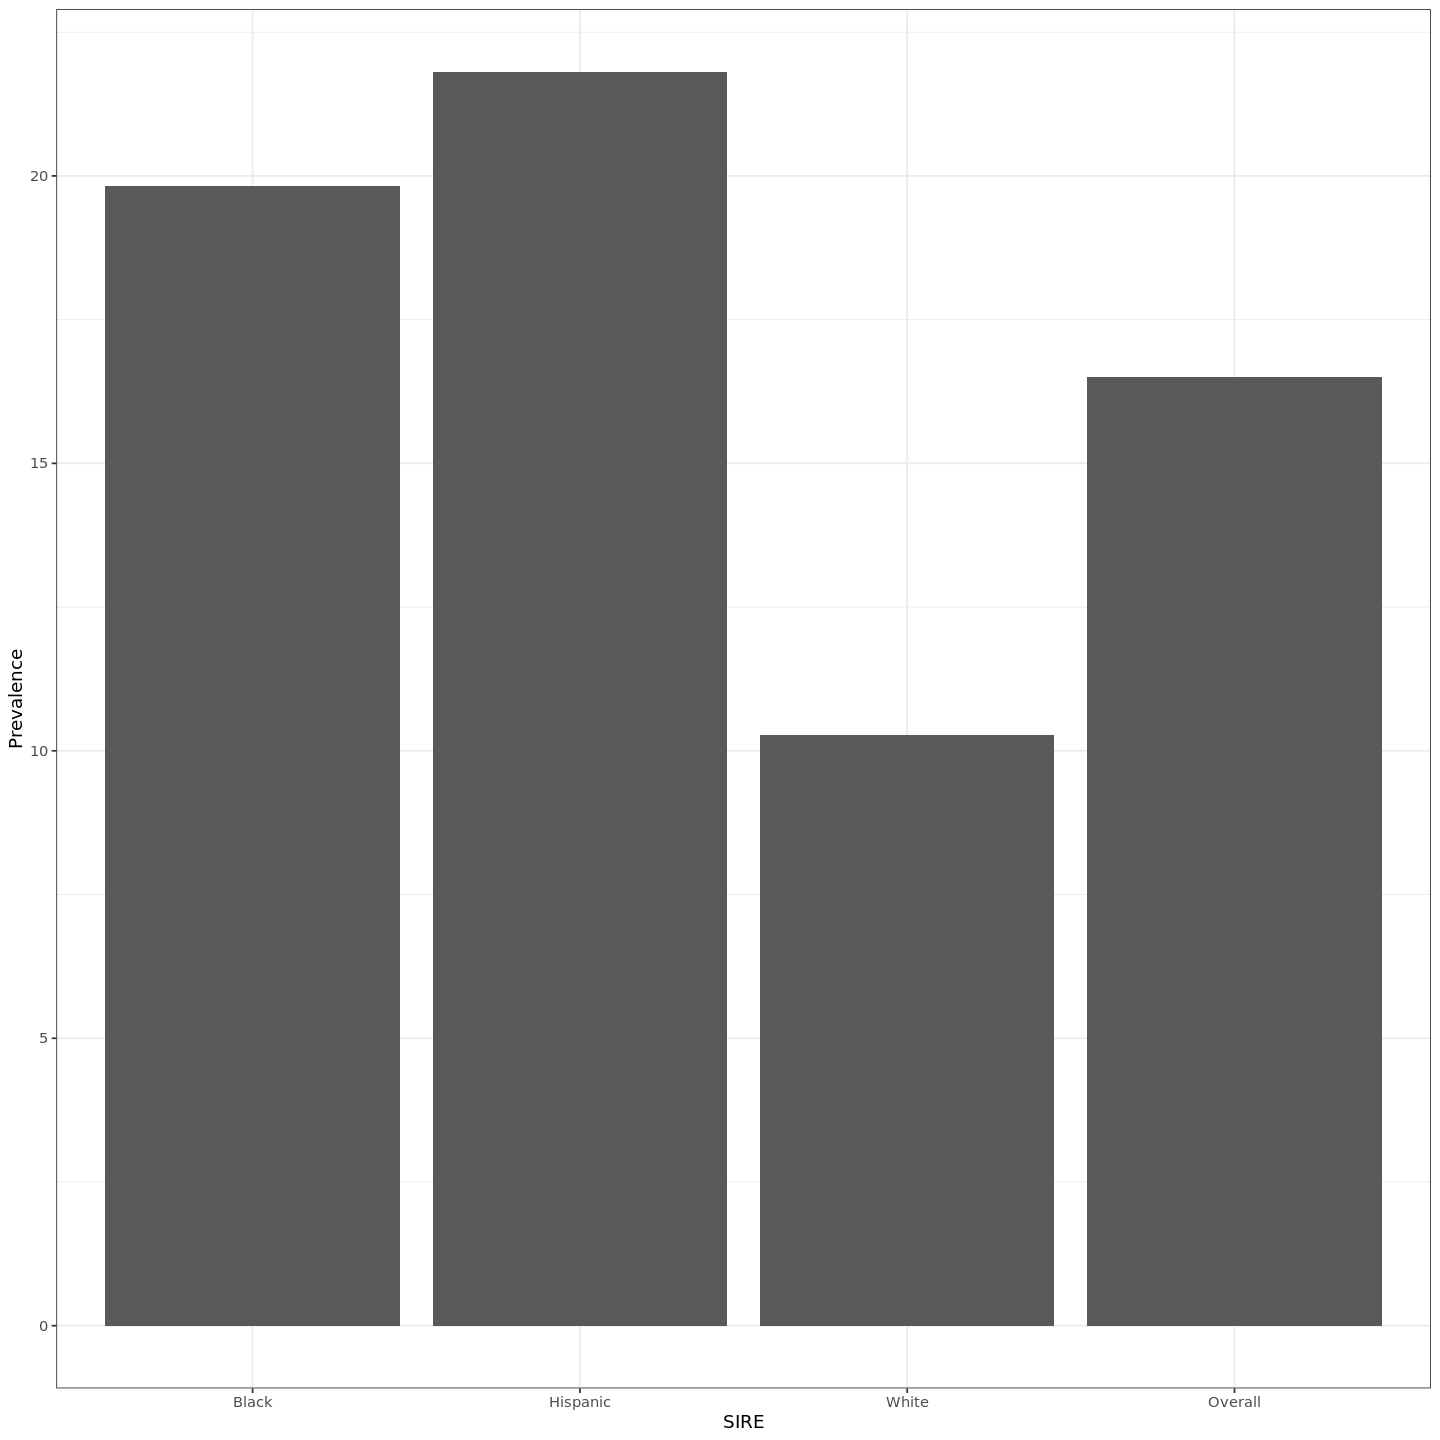

In [138]:
# Generating simple plot of adjusted prevalence estimates
ggplot(data = plot_df, mapping = aes(x = SIRE, y = Prevalence)) +
geom_bar(stat = 'identity') +
theme_bw()

We can display the confidence intervals we've calculated by adding a geom_errorbar object. We'll set the lower bound of our error bars to be our prevalence estimates minus our bounds and we'll set the upper bounds of our error bars to be our prevalence estimates plus our bounds:

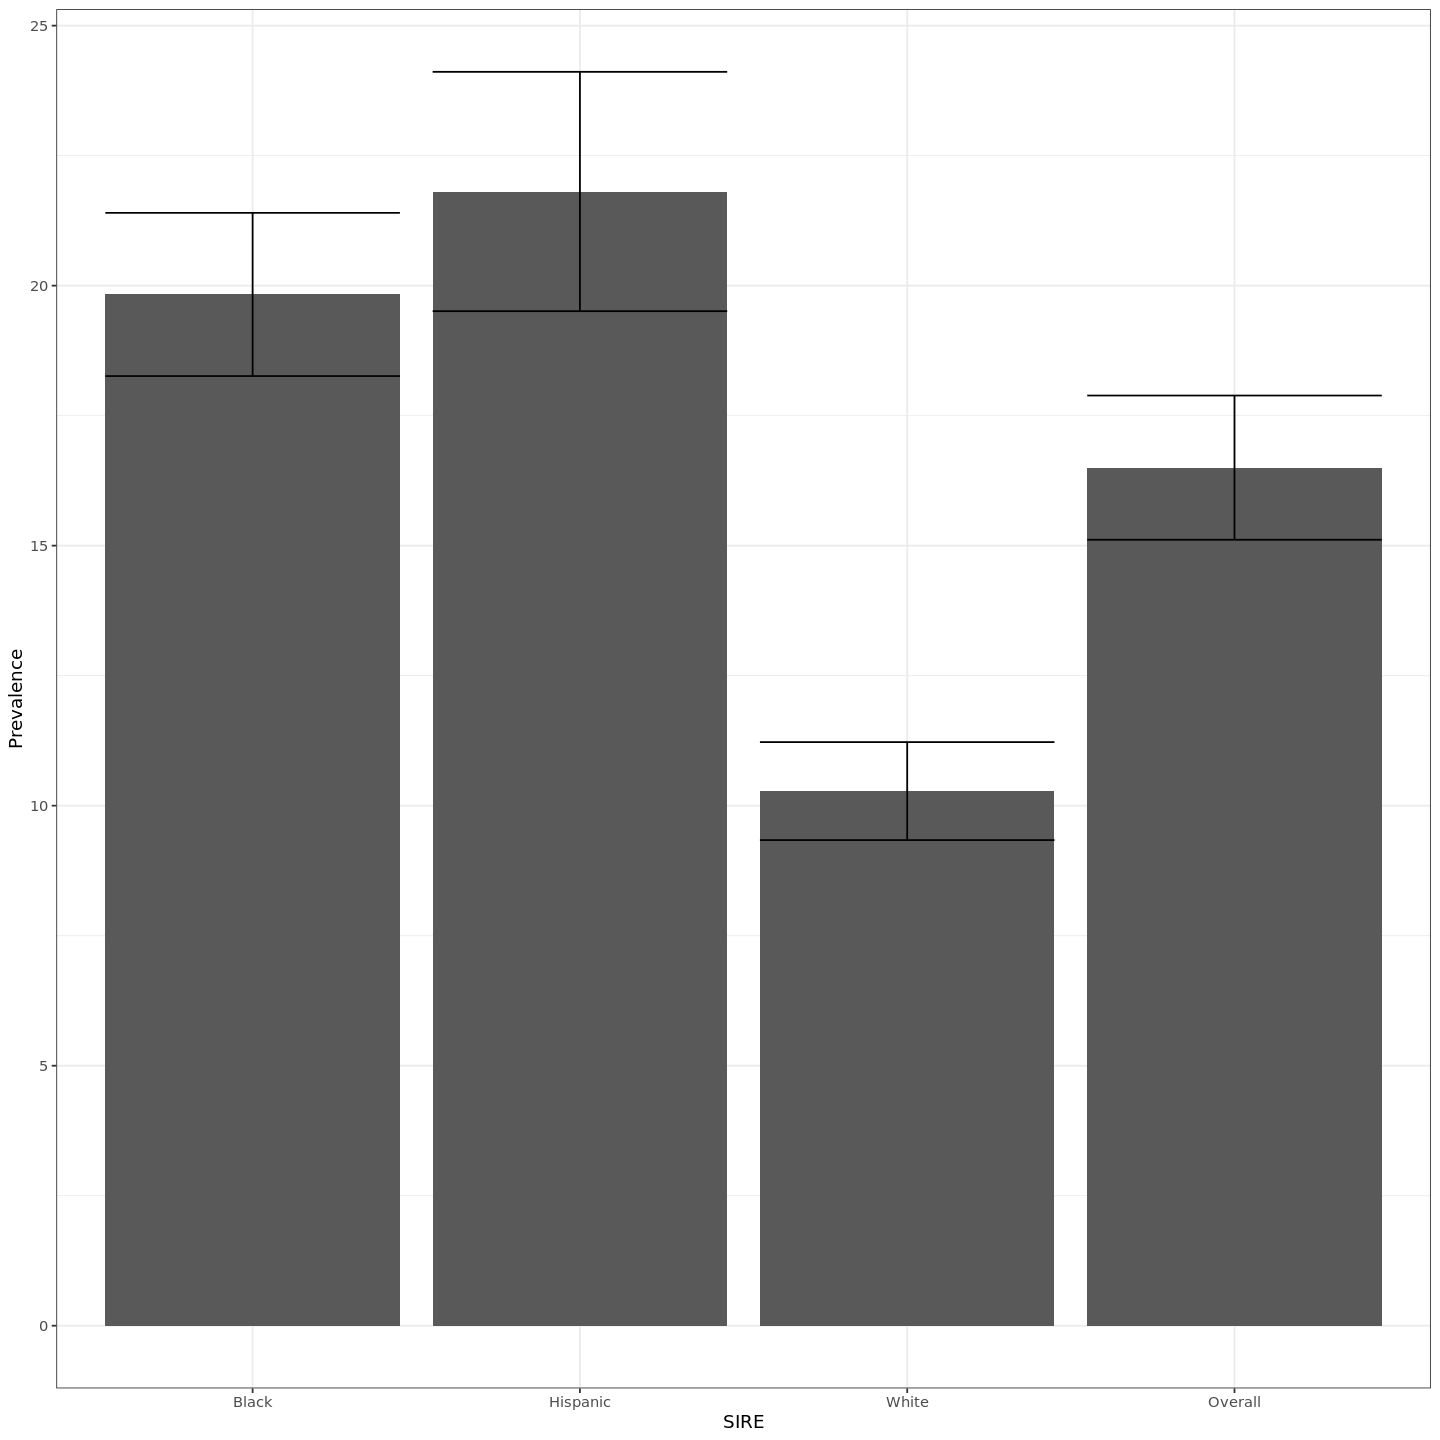

In [139]:
ggplot(data = plot_df, mapping = aes(x = SIRE, y = Prevalence)) +
geom_bar(stat = 'identity') +
# Displaying 95% confidence intervals
geom_errorbar(aes(ymin=Prevalence-CI, ymax=Prevalence+CI)) +
theme_bw()

Our bar plot now shows all the information we want it to display. However, it's not very visually appealling in its current form. One way in which we can improve the aesthetics of our plot is to narrow the width of the error bars and the bars themselves. We can do this by adjusting the 'width' parameter of both geom_bar() and geom_errorbar(): 

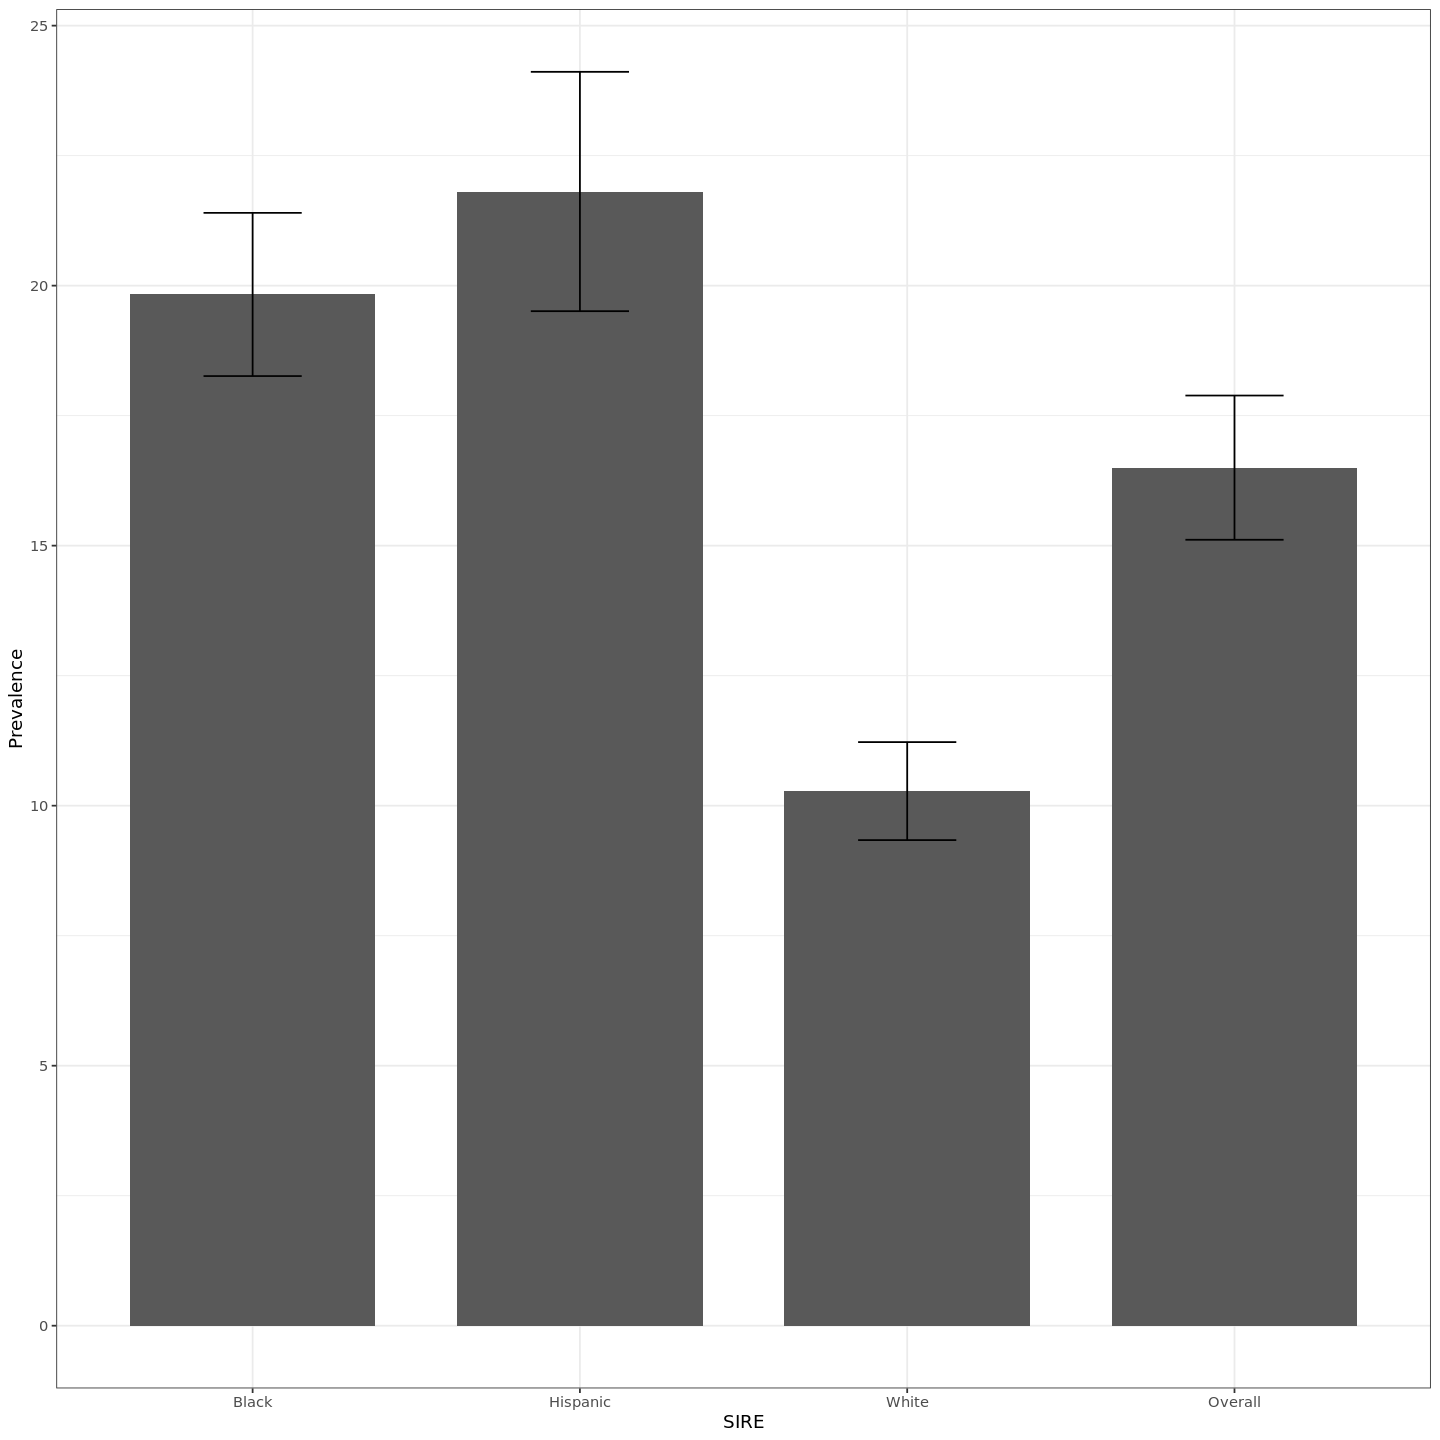

In [140]:
ggplot(data = plot_df, mapping = aes(x = SIRE, y = Prevalence)) +
# Specifying width of bars
geom_bar(stat = 'identity', width = 0.75) +
geom_errorbar(aes(ymin=Prevalence-CI, ymax=Prevalence+CI, width = 0.3)) +
theme_bw()

For some visual distinction, we can assign each of our bars a different color using the scale_fill_manual() function:

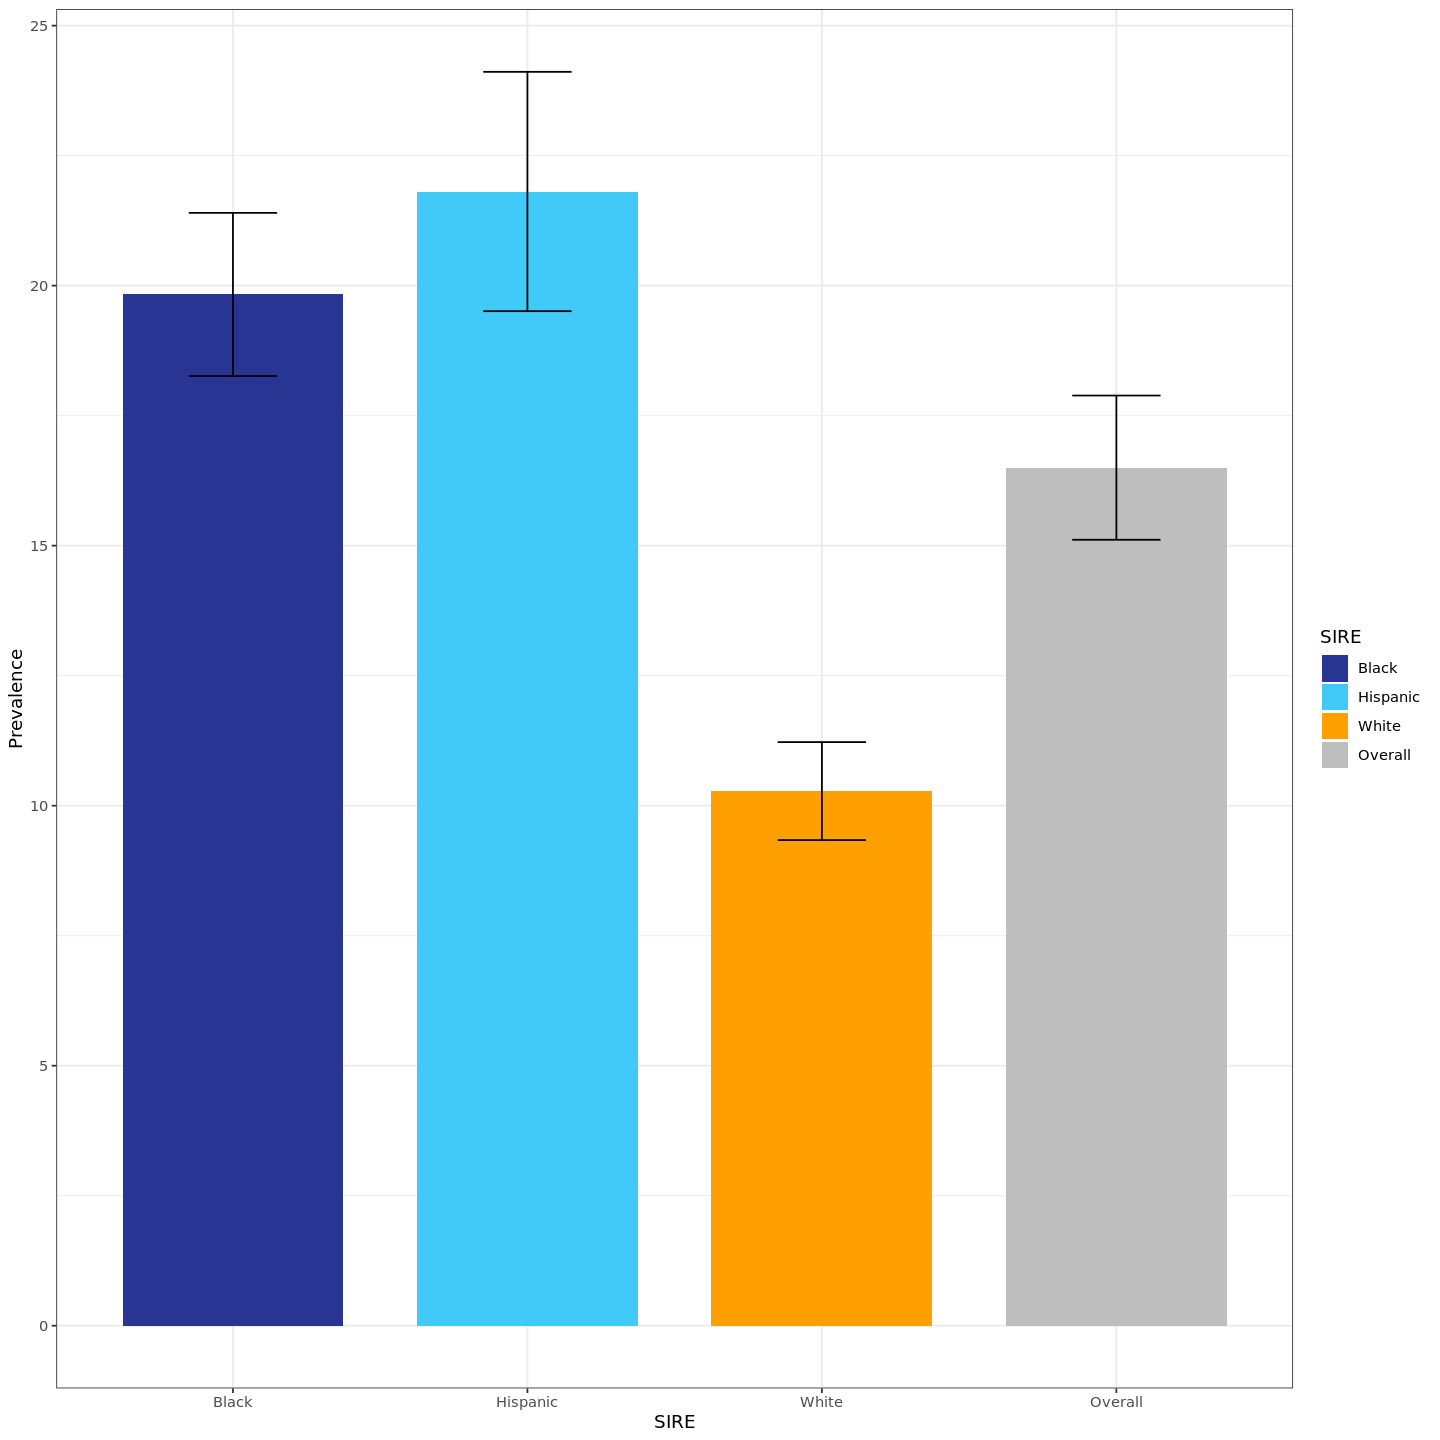

In [141]:
# Specify that we'd like to fill that bars by SIRE group
ggplot(data = plot_df, mapping = aes(x = SIRE, y = Prevalence, fill = SIRE)) +
geom_bar(stat = 'identity', width = 0.75) +
geom_errorbar(aes(ymin=Prevalence-CI, ymax=Prevalence+CI, width = 0.3)) +
theme_bw() +
# Specifying colors for each SIRE group
scale_fill_manual(values = c('#283593','#41C9F8','#FFA000','gray'))

To make our plot more legible, we can increase the font size of our axis, tick, and legend text by adjusting parameters for the theme() function:

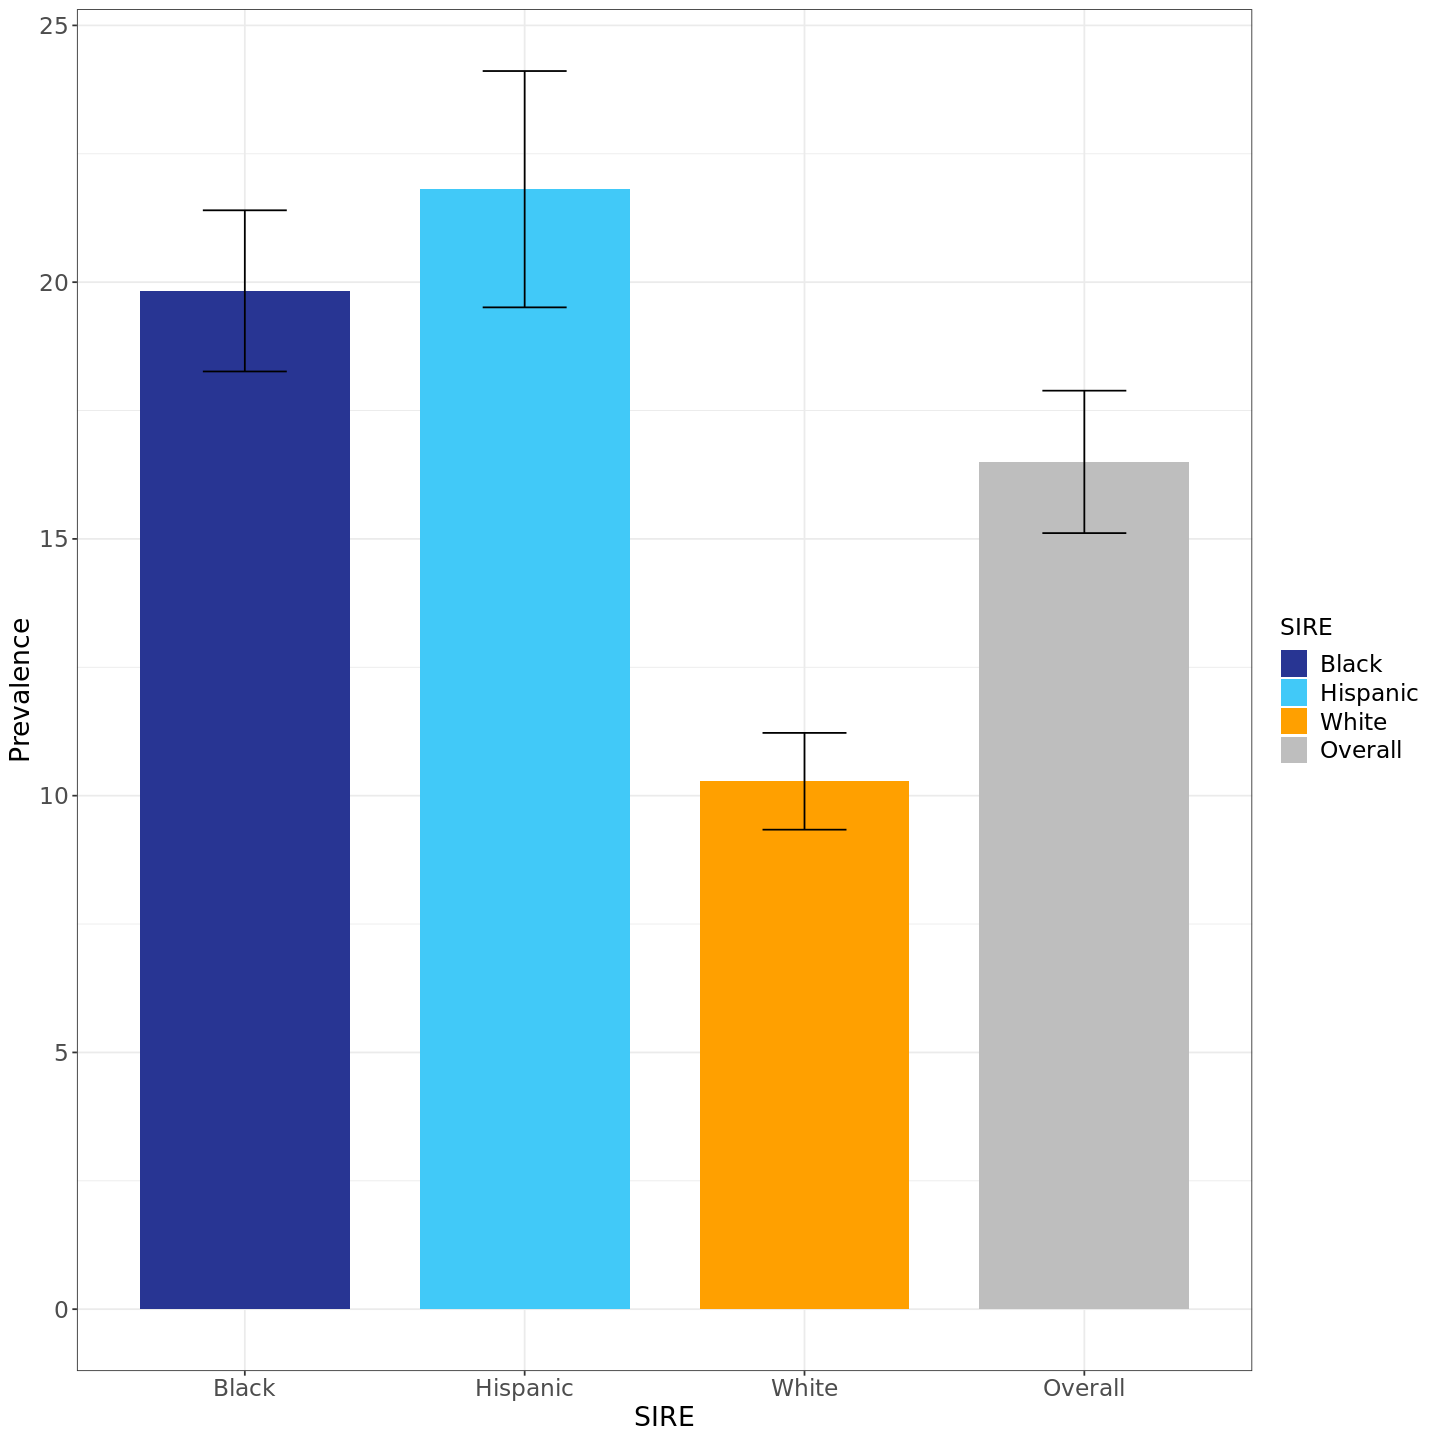

In [142]:
ggplot(data = plot_df, mapping = aes(x = SIRE, y = Prevalence, fill = SIRE)) +
geom_bar(stat = 'identity', width = 0.75) +
geom_errorbar(aes(ymin=Prevalence-CI, ymax=Prevalence+CI, width = 0.3)) +
theme_bw() +
# Increasing the font size of plot text
theme(axis.title = element_text(size = 16), axis.text = element_text(size = 14), legend.text = element_text(size = 14), legend.title = element_text(size = 14)) +
scale_fill_manual(values = c('#283593','#41C9F8','#FFA000','gray'))

Those are all the visual adjustments we'll be making for this plot. There are many other functions and parameters in the ggplot package that can be used to tweak the appearance of your plots, so feel free to experiment with them to see what works best for you. 

We can use this same suite of plotting functions to visually compare our adjusted prevalence estimates to both the unadjusted and national estimates we saw earlier. We'll begin, as always, by assembling a data tibble with the data we wish to plot. Thankfully, much of this work has already been done. The 'combined_df' tibble we assembled earlier contains values for both our unadjusted and national estimates:

In [143]:
# Displaying previously assembled plotting data
combined_df

SIRE,Prevalence,Estimate
<fct>,<dbl>,<chr>
Black,13.20000,National
Hispanic,12.80000,National
White,7.60000,National
Overall,10.74000,National
Black,23.19289,Cohort
Hispanic,26.86553,Cohort
White,11.15259,Cohort
Overall,16.21800,Cohort


We'll be combining this data with 'plot_df', which contains our adjusted prevalence estimates. Let's have another look at the tibble:

In [144]:
plot_df

SIRE,Prevalence,CI
<fct>,<dbl>,<dbl>
Black,19.83,1.5691523
Hispanic,21.81,2.3012655
White,10.28,0.9422129
Overall,16.50,1.3867051


While this tibble has values for SIRE and prevalence, we need an 'Estimate' column to make known that these values represent our adjusted estimates. Having this column is what also enables 'plot_df' to be merged with 'combined_df': 

In [145]:
# Adding an 'Estimate' column to our current plotting data
plot_df$Estimate = rep('Cohort (Adjusted)', 4)
# Displaying updated plotting data
plot_df

SIRE,Prevalence,CI,Estimate
<fct>,<dbl>,<dbl>,<chr>
Black,19.83,1.5691523,Cohort (Adjusted)
Hispanic,21.81,2.3012655,Cohort (Adjusted)
White,10.28,0.9422129,Cohort (Adjusted)
Overall,16.50,1.3867051,Cohort (Adjusted)


The two tibbles can now be merged. We'll drop the 'CI' column from 'plot_df' to ensure the two tibbles have the same three colums:

In [146]:
# Combining previous plotting data with current plotting data
combined_df2 = rbind(plot_df[c('SIRE','Prevalence','Estimate')], combined_df)
# Displaying combined data tibble
combined_df2

SIRE,Prevalence,Estimate
<fct>,<dbl>,<chr>
Black,19.83000,Cohort (Adjusted)
Hispanic,21.81000,Cohort (Adjusted)
White,10.28000,Cohort (Adjusted)
Overall,16.50000,Cohort (Adjusted)
Black,13.20000,National
Hispanic,12.80000,National
White,7.60000,National
Overall,10.74000,National
Black,23.19289,Cohort


We can now plot all three type 2 diabetes prevalence estimates together using a grouped bar plot. We'll apply the same plotting functions and parameters we used for our previous plot to improve this plot's appearance:

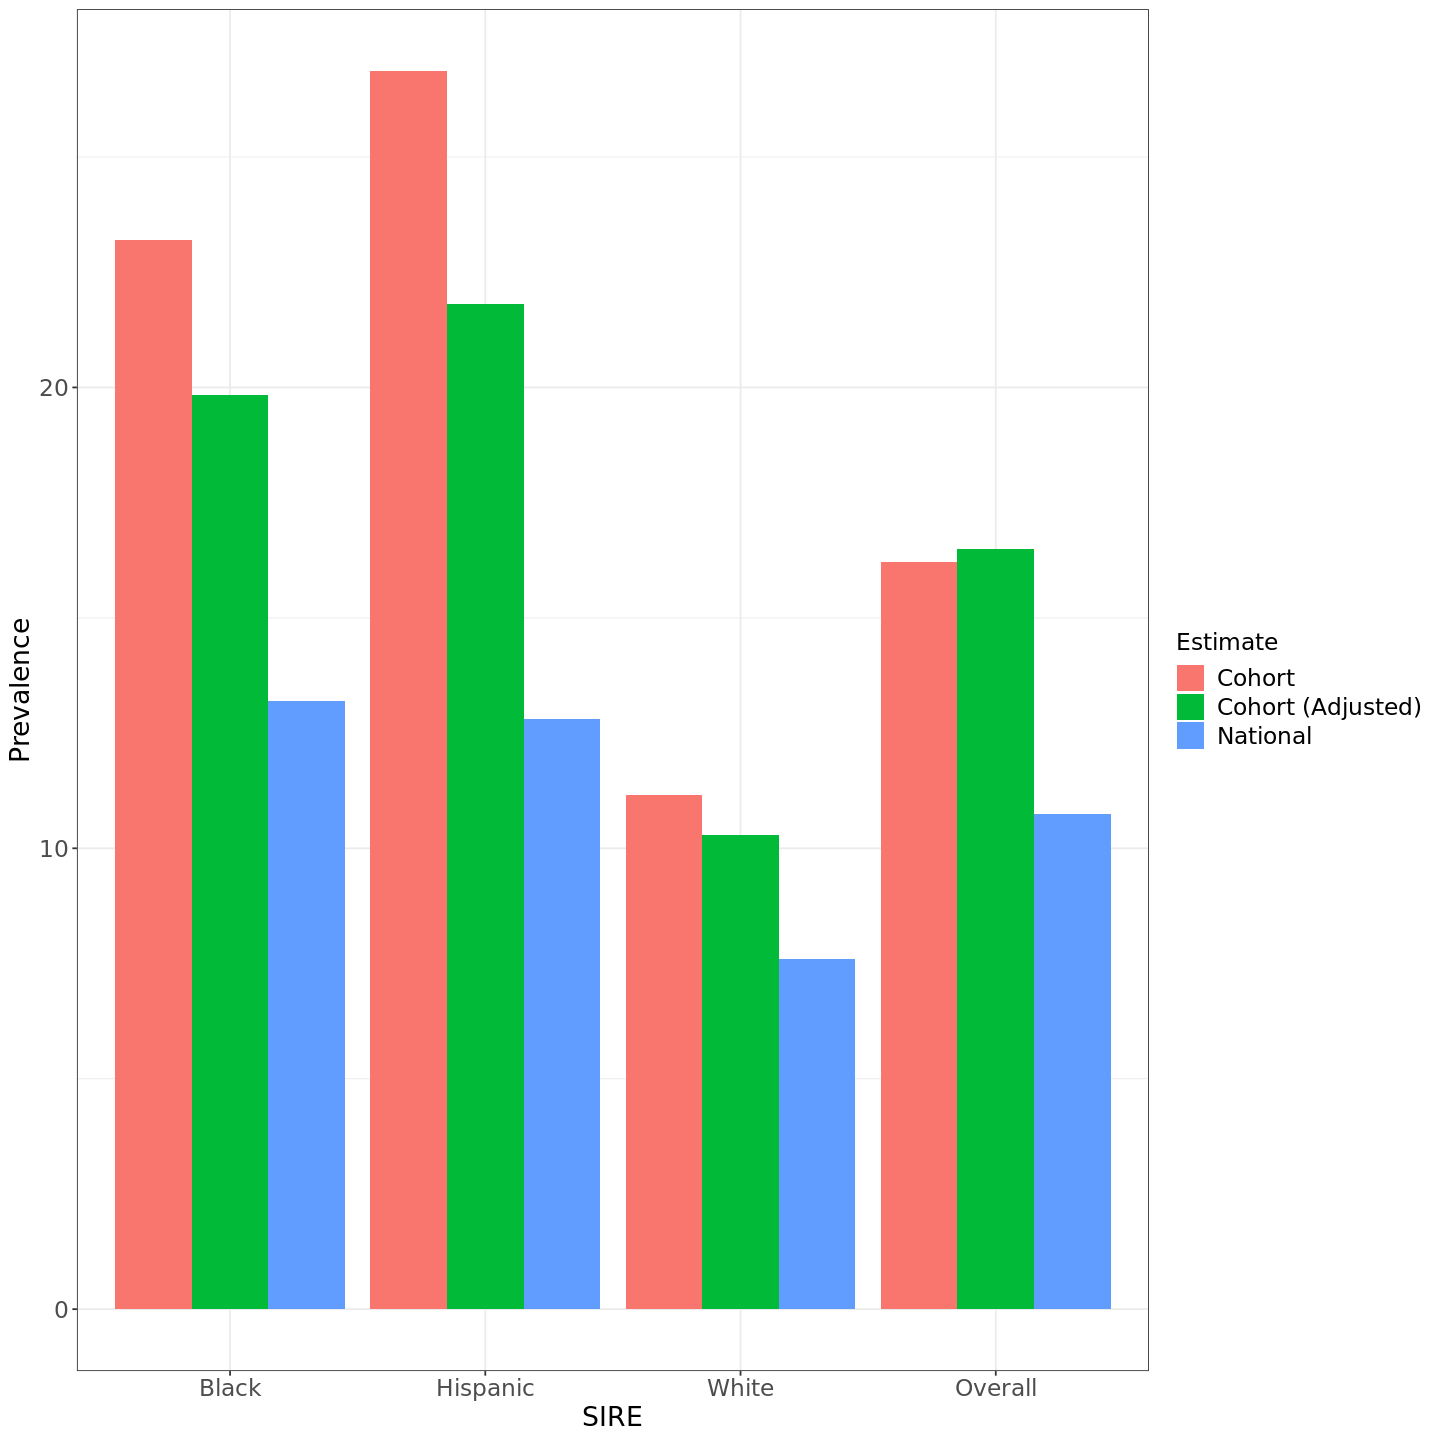

In [147]:
# Plotting table of raw prevalence estimates
ggplot(data = combined_df2, mapping = aes(x = SIRE, y = Prevalence, fill = Estimate)) +
# Specify that we'd like a grouped bar plot using the argument 'position = 'dodge''
geom_bar(stat = 'identity', position = 'dodge') +
theme_bw() +
theme(axis.title = element_text(size = 16), axis.text = element_text(size = 14), legend.text = element_text(size = 14), legend.title = element_text(size = 14))